# Data Dictionary

|Attribute|Description
----------|-----------
InvoiceNo| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode| Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description| Product (item) name. Nominal.
Quantity| The quantities of each product (item) per transaction. Numeric.
InvoiceDate| Invoice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice| Unit price. Numeric, Product price per unit in sterling.
CustomerID| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country| Country name. Nominal, the name of the country where each customer resides.

# 0.0 Imports

In [2]:
import pandas as pd
import inflection
from src import GeneralUtils  as gu
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics as mt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
import sklearn.manifold as man
#import umap as um
import umap.umap_ as um

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style('darkgrid')

# 0.1 Load Data

In [4]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 1.0. Data Description

In [6]:
df_description = df_raw.drop('Unnamed: 8', axis=1)

In [7]:
df_description.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Renaming Columns

In [8]:
old_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity','InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

df_description.columns = new_cols

In [9]:
df_description['description'] = df_description['description'].str.lower()

In [10]:
df_description.sort_values(['invoice_date', 'description'])

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
143414,548701,23007,spaceboy baby gift set,1,1-Apr-17,16.95,17629.0,United Kingdom
143694,548711,22906,12 message cards with envelopes,2,1-Apr-17,1.65,18116.0,United Kingdom
144000,548715,22906,12 message cards with envelopes,6,1-Apr-17,1.65,17758.0,United Kingdom
143573,548708,84461,12 pink hen+chicks in basket,1,1-Apr-17,2.55,13269.0,United Kingdom
144035,548715,21457,2 picture book eggs easter ducks,6,1-Apr-17,1.25,17758.0,United Kingdom
...,...,...,...,...,...,...,...,...
335644,566290,84836,zinc metal heart decoration,2,9-Sep-17,1.25,14456.0,United Kingdom
335748,566291,84836,zinc metal heart decoration,3,9-Sep-17,1.25,12965.0,United Kingdom
335588,566290,23153,zinc sweetheart wire letter rack,2,9-Sep-17,3.75,14456.0,United Kingdom
334150,566233,23145,zinc t-light holder star large,12,9-Sep-17,0.95,12635.0,Germany


## 1.2. Data Dimension

In [11]:
print(f'Number of Rows: {df_description.shape[0]}')
print(f'Number of Columnss: {df_description.shape[1]}')

Number of Rows: 541909
Number of Columnss: 8


## 1.3. Data Types & Missing Values

In [12]:
gu.sum_table(df_description)

,Name,dtypes,Uniques,Missing,Missing %
0,invoice_no,object,25900,0,0.00
1,stock_code,object,4070,0,0.00
2,description,object,4206,1454,0.27
3,quantity,int64,722,0,0.00
4,invoice_date,object,305,0,0.00
5,unit_price,float64,1630,0,0.00
6,customer_id,float64,4372,135080,24.93
7,country,object,38,0,0.00


## 1.4.  Handling Missing Values

Checking if there are invoice number of elements with missing customer ID in other part of the dataset, so we can fill the missing values.

In [13]:
invoice_no_of_missing_customer_ids = df_description.query('customer_id.isnull()').invoice_no.values
df_description.loc[df_description.invoice_date.isin(invoice_no_of_missing_customer_ids)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


There are no invoice numbers in other parts of the dataset. So, in this cycle, I opted to remove the NAs and see how the model performs. In another cycle, I will find other ways to treat this.

In [14]:
# description
df_description = df_description.dropna(subset=['description', 'customer_id'], axis=0)
print(f'Removed data: {1 - (df_description.shape[0]/df_raw.shape[0]):.2%}')

Removed data: 24.93%


In [15]:
df_description.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [16]:
df_description.shape[0]

406829

## 1.5. Fixing Data Types

In [17]:
df_description.invoice_date = pd.to_datetime(df_description.invoice_date)
df_description.customer_id = df_description.customer_id.astype(int)

In [18]:
df_description.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom


In [19]:
df_description.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.6. Descriptive Statistics

### 1.6.1 Numerical Attributes

In [20]:
num_att = df_description.select_dtypes(include=['float64', 'int64'])
cat_att = df_description.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

In [21]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'var', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,min,max,range,mean,median,var,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,61848.392291,248.693370,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,4804.591645,69.315162,452.219019,246924.542988


In [22]:
df_description.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99, 0.997])[['quantity', 'unit_price']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,99.7%,max
quantity,406829.0,12.061303,248.693370,-80995.0,-2.00,1.00,1.00,1.00,5.00,12.00,24.00,36.0,120.0,271.032,80995.0
unit_price,406829.0,3.460471,69.315162,0.0,0.21,0.42,0.55,0.85,1.95,4.15,6.75,8.5,15.0,24.950,38970.0


### <font color='red'> 1.6.2  Further Analysis needed </font>

Quantity with negative values -> cancellation

Unit price 0 -> promotion?

### 1.6.1 Categorical Attributes

**Invoice Number with at least one string**

In [23]:
# df_description.inoice_no.astype(int)
letter_invoices = df_description.loc[df_description.invoice_no.str.contains('C')]

print('Total Number of Cancelation invoices:', len(letter_invoices))
print('Total Number of Negative quantites:', len(letter_invoices.query('quantity < 0')))

Total Number of Cancelation invoices: 8905
Total Number of Negative quantites: 8905


**Stock codes with at least one string**

In [24]:
df_description.loc[~df_description.stock_code.str.isdigit()].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2016-11-29,2.55,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2016-11-29,3.39,17850,United Kingdom
45,536370,POST,postage,3,2016-11-29,18.00,12583,France


In [26]:
df_description.loc[df_description.stock_code.str.isalpha()].stock_code.value_counts()

# Remove stovk_code in [POST, M, D, DOT, CRUK, PADS]

POST    1196
M        465
D         77
DOT       16
CRUK      16
PADS       4
Name: stock_code, dtype: int64

**Stock codes that are only strings**

In [27]:
df_description.loc[df_description.stock_code.str.isalpha()].head()

# delete Description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,postage,3,2016-11-29,18.00,12583,France
141,C536379,D,discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,postage,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,postage,1,2016-11-29,18.00,12662,Germany
2239,536569,M,manual,1,2016-11-29,1.25,16274,United Kingdom


In [28]:
df_description.value_counts('country')

country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


In [29]:
df_description.groupby('country').nunique()[['customer_id']].reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


What to do if a customer has a negative spent overall. In this dataset the cancelation code doesn't match the transaction code
Some customer id where null and removed, so we are not able to match the cancelation with the original order.

# 3.0. Variables Filtering

In [33]:
df_filter = df_description.copy()
columns = ['invoice_no', 'quantity', 'invoice_date', 'unit_price', 'customer_id']

Numerical

In [34]:
df_filter.query('unit_price >= 0.04')
df_filter[['customer_id', 'description', 'quantity', 'unit_price']].query('unit_price < 0.04').sort_values('unit_price', ascending=False)

,customer_id,description,quantity,unit_price
4287,15838,rotating silver angels t-light hldr,-9360,0.030
182729,12901,discount,-240,0.030
355050,16422,manual,-120,0.030
108088,16422,discount,-720,0.010
359871,16198,pads to match all cushions,1,0.001
361741,13405,bank charges,1,0.001
279045,15618,pads to match all cushions,1,0.001
157195,13952,pads to match all cushions,1,0.001
454463,13081,set of 9 black skull balloons,20,0.000
446794,13985,mini lights woodland mushrooms,1,0.000


Categorical

In [35]:
# removing stock_codes that are only letters
df_filter = df_filter.query("~stock_code.isin(['POST', 'M', 'D', 'DOT', 'CRUK', 'PADS'])")

# removing European Community and Unspecified
df_filter = df_filter.query("~country.isin(['European Community', 'Unspecified'])")

dict_country = {'EIRE': 'Ireland', 'RSA': 'South Africa'}
df_filter.country = df_filter.country.apply(lambda x: 'Ireland' if x == 'EIRE' else 'South Africa' if x == 'RSA' else x)

In [36]:
df_cancelation = df_filter.query("quantity < 0 or invoice_no.str.contains('C')")[columns]
df_transaction = df_filter.query('quantity > 0')[columns]

In [37]:
print('Number of rows Cancelation:', df_cancelation.shape[0])
print('Number of rows Transaction:', df_transaction.shape[0])

Number of rows Cancelation: 8539
Number of rows Transaction: 396214


In [38]:
df_cancelation.loc[df_cancelation.invoice_no.str.isdigit()]

,invoice_no,quantity,invoice_date,unit_price,customer_id


In [39]:
df_transaction.loc[~df_transaction.invoice_no.str.isdigit()]

,invoice_no,quantity,invoice_date,unit_price,customer_id


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 2.0. Feature Engineering

In [42]:
df_feature = df_filter.copy()
df_feature_transaction = df_transaction.copy()
df_feature_cancelation = df_cancelation.copy()

In [43]:
df_feature_transaction['gross_revenue'] = df_feature_transaction.quantity * df_feature_transaction.unit_price

# Recency
diff = df_filter.invoice_date.max() - df_feature_transaction.groupby('customer_id').max()['invoice_date']
recency = pd.DataFrame(diff).reset_index().rename(columns={'invoice_date': 'recency'})

recency['recency'] = recency['recency'].dt.days
df_feature = df_feature.merge((recency), how='left', on='customer_id')


# Frequency
frequency = df_feature_transaction.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'frequency'})
df_feature = df_feature.merge((frequency), how='left', on='customer_id')


# Monetary
monetary = df_feature_transaction.groupby('customer_id').sum(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'monetary'})
df_feature = df_feature.merge((monetary), how='left', on='customer_id')

# Total Cancelation
df_feature_cancelation['total_returned'] = -df_feature_cancelation.quantity * df_feature_cancelation.unit_price
total_returned = df_feature_cancelation.groupby('customer_id').sum()[['total_returned']].reset_index()

df_feature = df_feature.merge(total_returned, how='left', on='customer_id')

cancelations = df_feature_cancelation.groupby('customer_id').nunique()[['invoice_no']].reset_index().rename(columns={'invoice_no': 'number_of_cancelations'})
df_feature = df_feature.merge(cancelations, how='left', on='customer_id')

df_feature.isnull().sum()

C:\Users\Bteix\AppData\Local\Temp\ipykernel_19640\2252644122.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_returned = df_feature_cancelation.groupby('customer_id').sum()[['total_returned']].reset_index()


invoice_no                     0
stock_code                     0
description                    0
quantity                       0
invoice_date                   0
unit_price                     0
customer_id                    0
country                        0
recency                       84
frequency                     84
monetary                      84
total_returned            161603
number_of_cancelations    161603
dtype: int64

In [45]:
df_feature.query('monetary.isnull()')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,recency,frequency,monetary,total_returned,number_of_cancelations
3115,C536760,22175,pink owl soft toy,-1,2016-11-30,2.95,17547,United Kingdom,NaN,NaN,NaN,11.80,1.0
3116,C536760,22273,feltcraft doll molly,-3,2016-11-30,2.95,17547,United Kingdom,NaN,NaN,NaN,11.80,1.0
3665,C536814,21527,red retrospot traditional teapot,-2,2016-11-30,7.95,13958,United Kingdom,NaN,NaN,NaN,102.45,1.0
3666,C536814,72799E,ivory pillar candle silver flock,-6,2016-11-30,2.95,13958,United Kingdom,NaN,NaN,NaN,102.45,1.0
3667,C536814,85066,cream sweetheart mini chest,-2,2016-11-30,12.75,13958,United Kingdom,NaN,NaN,NaN,102.45,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305564,C572228,22111,scottie dog hot water bottle,-10,2017-10-19,3.45,15728,United Kingdom,NaN,NaN,NaN,134.80,1.0
308064,C572410,23174,regency sugar bowl green,-2,2017-10-22,3.75,16742,United Kingdom,NaN,NaN,NaN,464.90,1.0
308065,C572410,22699,roses regency teacup and saucer,-168,2017-10-22,2.55,16742,United Kingdom,NaN,NaN,NaN,464.90,1.0
308066,C572410,23170,regency tea plate roses,-20,2017-10-22,1.45,16742,United Kingdom,NaN,NaN,NaN,464.90,1.0


In [80]:
df_feature_transaction.fillna(0, inplace=True)

In [81]:
df_filter_aux = df_filter.copy()
df_filter_aux['gross_revenue'] = df_filter_aux.quantity * df_filter_aux.unit_price

avg_ticket = df_filter_aux.groupby('customer_id').mean(numeric_only=True).gross_revenue.reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
#
df_feature_transaction = df_feature_transaction.merge((avg_ticket), how='left', on='customer_id')
#
df_feature_transaction.isnull().sum()

invoice_no                0
quantity                  0
invoice_date              0
unit_price                0
customer_id               0
gross_revenue             0
recency                   0
frequency                 0
monetary                  0
total_returned            0
number_of_cancelations    0
avg_ticket                0
dtype: int64

In [82]:
df_feature_transaction

,invoice_no,quantity,invoice_date,unit_price,customer_id,gross_revenue,recency,frequency,monetary,total_returned,number_of_cancelations,avg_ticket
0,536365,6,2016-11-29,2.55,17850,15.30,372,34,5391.21,102.58,1.0,16.950737
1,536365,6,2016-11-29,3.39,17850,20.34,372,34,5391.21,102.58,1.0,16.950737
2,536365,8,2016-11-29,2.75,17850,22.00,372,34,5391.21,102.58,1.0,16.950737
3,536365,6,2016-11-29,3.39,17850,20.34,372,34,5391.21,102.58,1.0,16.950737
4,536365,6,2016-11-29,3.39,17850,20.34,372,34,5391.21,102.58,1.0,16.950737
...,...,...,...,...,...,...,...,...,...,...,...,...
397919,581587,12,2017-12-07,0.85,12680,10.20,0,4,862.81,0.00,0.0,16.592500
397920,581587,6,2017-12-07,2.10,12680,12.60,0,4,862.81,0.00,0.0,16.592500
397921,581587,4,2017-12-07,4.15,12680,16.60,0,4,862.81,0.00,0.0,16.592500
397922,581587,4,2017-12-07,4.15,12680,16.60,0,4,862.81,0.00,0.0,16.592500


In [83]:
columns = ['customer_id', 'recency', 'frequency', 'monetary', 'total_returned', 'number_of_cancelations', 'avg_ticket']
df_customers = df_feature_transaction.drop_duplicates('customer_id').copy()[columns]
df_customers.head()

,customer_id,recency,frequency,monetary,total_returned,number_of_cancelations,avg_ticket
0,17850,372,34,5391.21,102.58,1.0,16.950737
9,13047,31,10,3237.54,158.44,8.0,15.709694
26,12583,2,15,7281.38,94.04,3.0,28.634821
46,13748,95,5,948.25,0.00,0.0,33.866071
65,15100,333,3,876.00,240.90,3.0,105.850000


In [84]:
df_customers['total_spent'] = df_customers.monetary - df_customers.total_returned

**For this cycle I will remove customers tha have a returned value above the monetary value.**

In [85]:
removed = df_customers.query('(total_returned >= monetary)').shape[0]
percent = removed/df_customers.shape[0]
 
print(f'Number of elements Removed: {removed}\nPercetual removed: {percent:.2%}')
#df_customers.query('~(total_returned >= monetary)')

Number of elements Removed: 20
Percetual removed: 0.46%


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 4.0. Exploratory Data Analysis

In [86]:
df_eda = df_customers.copy()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 5.0. Data Preparation

In [87]:
df_prep = df_eda.copy()

In [88]:
std = Pipeline([('standard', pp.StandardScaler())])
minmax = Pipeline([('minmax', pp.MinMaxScaler())])
robust = Pipeline([('robust', pp.RobustScaler())])
cols = ['recency', 'frequency', 'monetary', 'total_returned', 'number_of_cancelations', 'total_spent', 'avg_ticket']
pass_cols = ['customer_id'] 
preprocess = ColumnTransformer([('pass', 'passthrough', pass_cols), ('minmax', minmax, cols)])


In [89]:
#df_prep_scaled = 
df_prep_scaled = pd.DataFrame(preprocess.fit_transform(df_prep))

In [90]:
cols = ['customer_id', 'recency', 'frequency', 'monetary', 'total_returned', 'number_of_cancelations', 'total_spent', 'avg_ticket']
df_prep_scaled.columns = cols

In [91]:
df_prep_scaled

,customer_id,recency,frequency,monetary,total_returned,number_of_cancelations,total_spent,avg_ticket
0,17850.0,0.997319,0.157895,0.019240,0.000609,0.021277,0.022996,0.041736
1,13047.0,0.083110,0.043062,0.011554,0.000940,0.170213,0.015123,0.041427
2,12583.0,0.005362,0.066986,0.025986,0.000558,0.063830,0.029761,0.044649
3,13748.0,0.254692,0.019139,0.003384,0.000000,0.000000,0.007531,0.045953
4,15100.0,0.892761,0.009569,0.003126,0.001430,0.063830,0.006415,0.063898
...,...,...,...,...,...,...,...,...
4334,13436.0,0.002681,0.000000,0.000703,0.000000,0.000000,0.004854,0.041601
4335,15520.0,0.002681,0.000000,0.001226,0.000000,0.000000,0.005376,0.042268
4336,13298.0,0.002681,0.000000,0.001285,0.000000,0.000000,0.005435,0.082382
4337,14569.0,0.002681,0.000000,0.000812,0.000000,0.000000,0.004962,0.042234


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 6.0. Feature Selection

In [92]:
df_fselect = df_prep.copy()[['customer_id', 'total_spent', 'recency', 'frequency', 'number_of_cancelations', 'avg_ticket']]
df_fselect_sc = df_prep_scaled.copy()[['customer_id', 'total_spent', 'recency', 'frequency', 'number_of_cancelations', 'avg_ticket']]

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 7.0. Hyperparameter Fine-Tuning

In [93]:
df_k = df_fselect_sc[['customer_id', 'total_spent', 'recency', 'frequency', 'number_of_cancelations', 'avg_ticket']].drop(columns=['customer_id']).copy().reset_index(drop=True)

In [94]:
df_k.head()

,total_spent,recency,frequency,number_of_cancelations,avg_ticket
0,0.022996,0.997319,0.157895,0.021277,0.041736
1,0.015123,0.083110,0.043062,0.170213,0.041427
2,0.029761,0.005362,0.066986,0.063830,0.044649
3,0.007531,0.254692,0.019139,0.000000,0.045953
4,0.006415,0.892761,0.009569,0.063830,0.063898


In [95]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

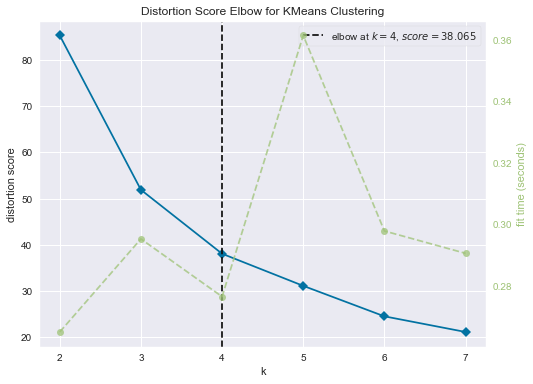

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, timing=False)
vis.fit(df_k)
vis.show()

## 7.2 Sillhoutte Score

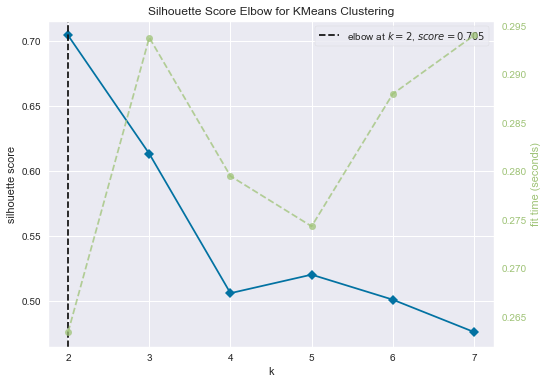

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [97]:
plt.figure(figsize=(8, 6))
kmeans = KMeans(init='random', n_init=10, max_iter=300, random_state=42)

vis = KElbowVisualizer(kmeans, k=clusters, metric='silhouette', timing=False)
vis.fit(df_k)
vis.show()

## 7.3 Sillhoutte Analysis

<Figure size 720x432 with 0 Axes>

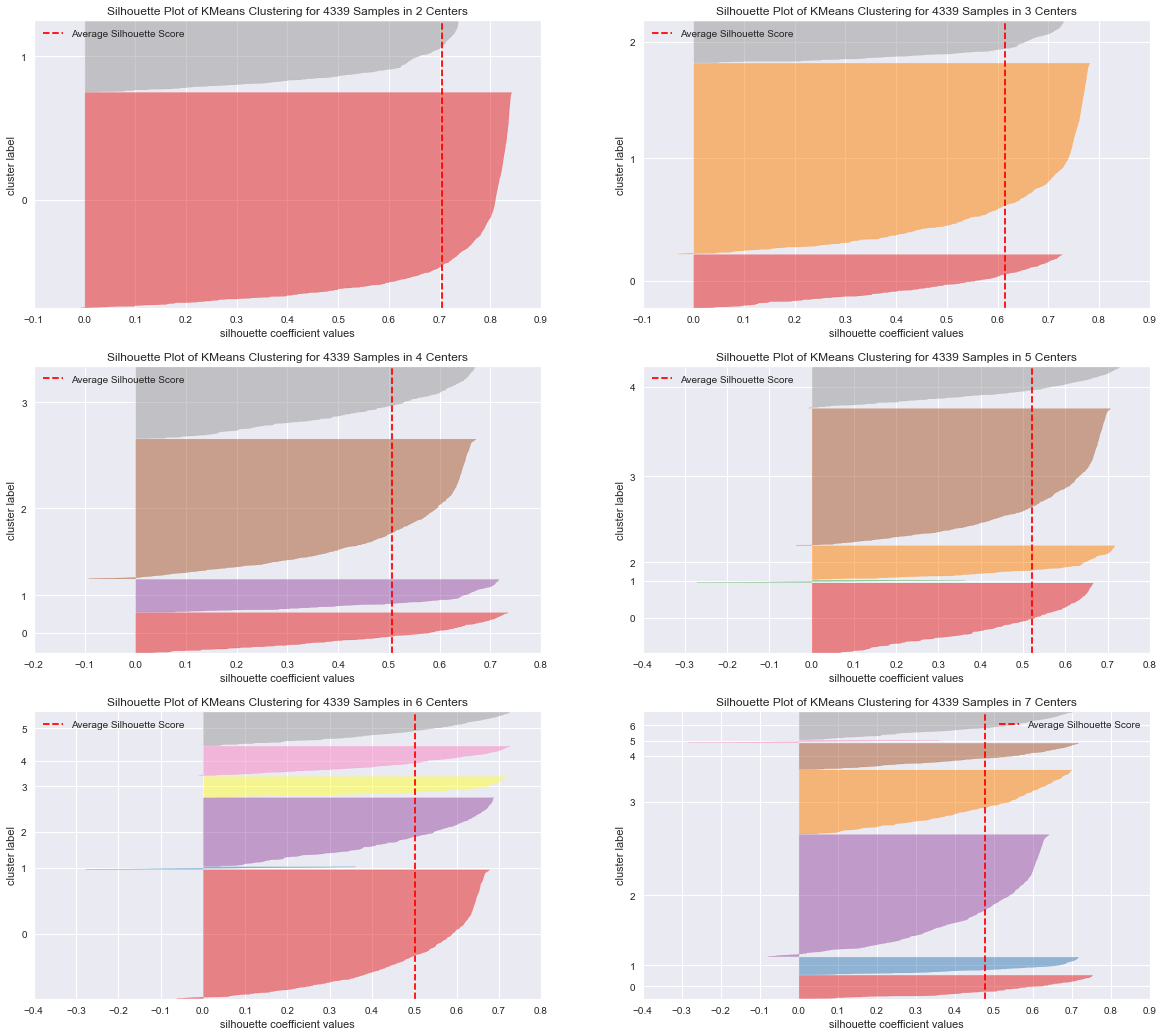

In [98]:
plt.figure(figsize=(10, 6))
n_clusters = [2, 3, 4, 5, 6, 7]
fig, ax = plt.subplots(3, 2, figsize=(20, 18))

for k in n_clusters:
    q, mod = divmod(k, 2)
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    vis = SilhouetteVisualizer(kmeans, color='yellowbricks', ax=ax[q-1][mod])
    vis.fit(df_k)
    vis.finalize()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 8.0. Model Training

## 8.1. K-Means

In [99]:
# model
n_cluster=4
kmeans = KMeans(init='random', n_clusters=n_cluster, n_init=10, max_iter=300, random_state=42)

# model training
labels = kmeans.fit_predict(df_k)
ss = mt.silhouette_score(df_k, labels)
wss = kmeans.inertia_

print(f'Silhouette Score: {ss}')
print(f'Within CLuster Sum of Squares: {wss}')

Silhouette Score: 0.506283880812159
Within CLuster Sum of Squares: 38.06480508131379


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 9.0. Cluster Analysis

## 9.1. Visualization

In [100]:
cluster_df = df_fselect.copy()
cluster_df_sc = df_fselect_sc.copy()
cluster_df['cluster'] = labels
cluster_df_sc['cluster'] = labels

e:\users\b_tc\anaconda3\envs\churnenv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


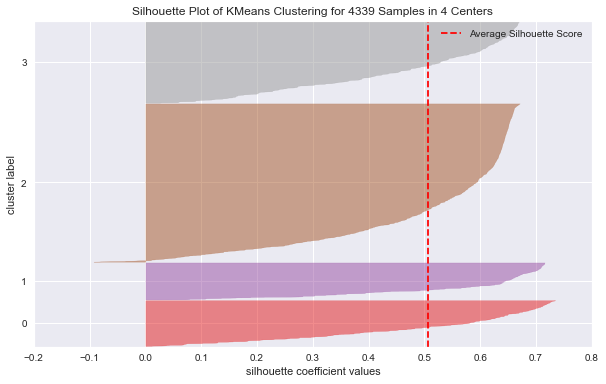

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4339 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [101]:
plt.figure(figsize=(10, 6))
vis = SilhouetteVisualizer(kmeans, color='yellowbricks')
vis.fit(df_k)
vis.show()

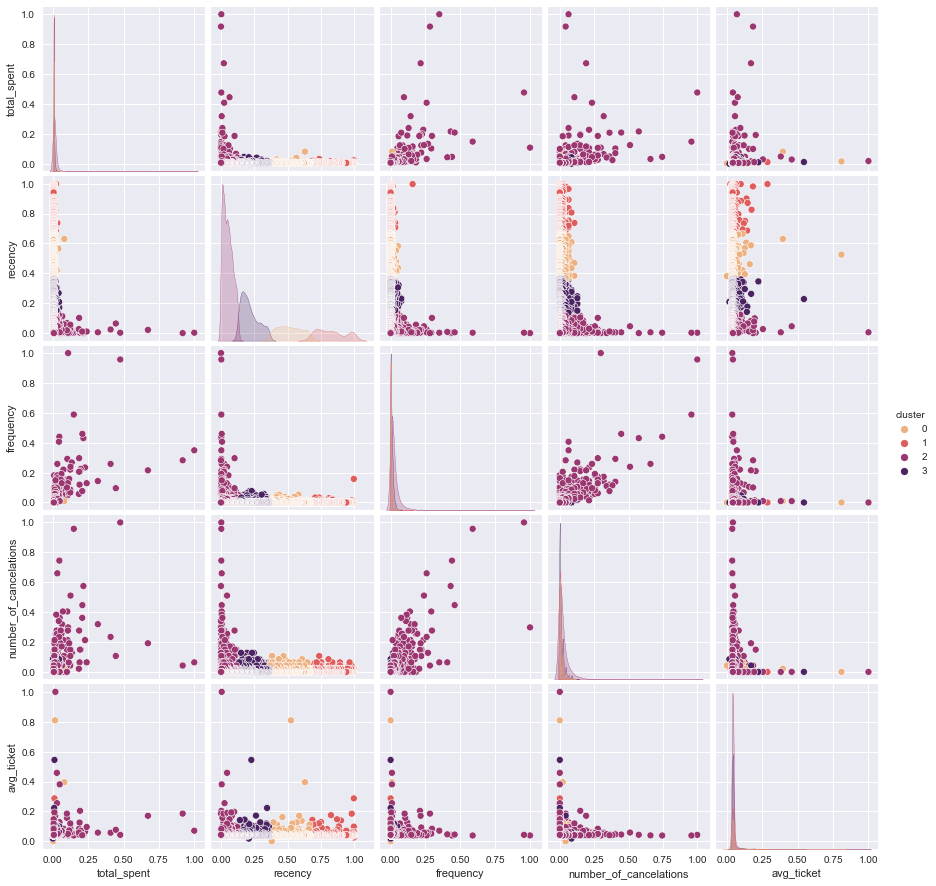

In [102]:
sns.pairplot(cluster_df_sc.drop(columns='customer_id'), hue='cluster', palette='flare')

In [103]:
X = df_fselect_sc.copy().drop(columns='customer_id')

# TSNE
tsne = man.TSNE(random_state=42, perplexity=50)

features_tsne = tsne.fit_transform(X)

#tsne_scaled = man.TSNE(random_state=42)
#
#features_tsne_scaled = tsne.fit_transform(X_scaled)

In [104]:
# UMAP

u_map = um.UMAP(n_neighbors=50, random_state=42)

X_umap = u_map.fit_transform(X)

## TSNE

<AxesSubplot:>

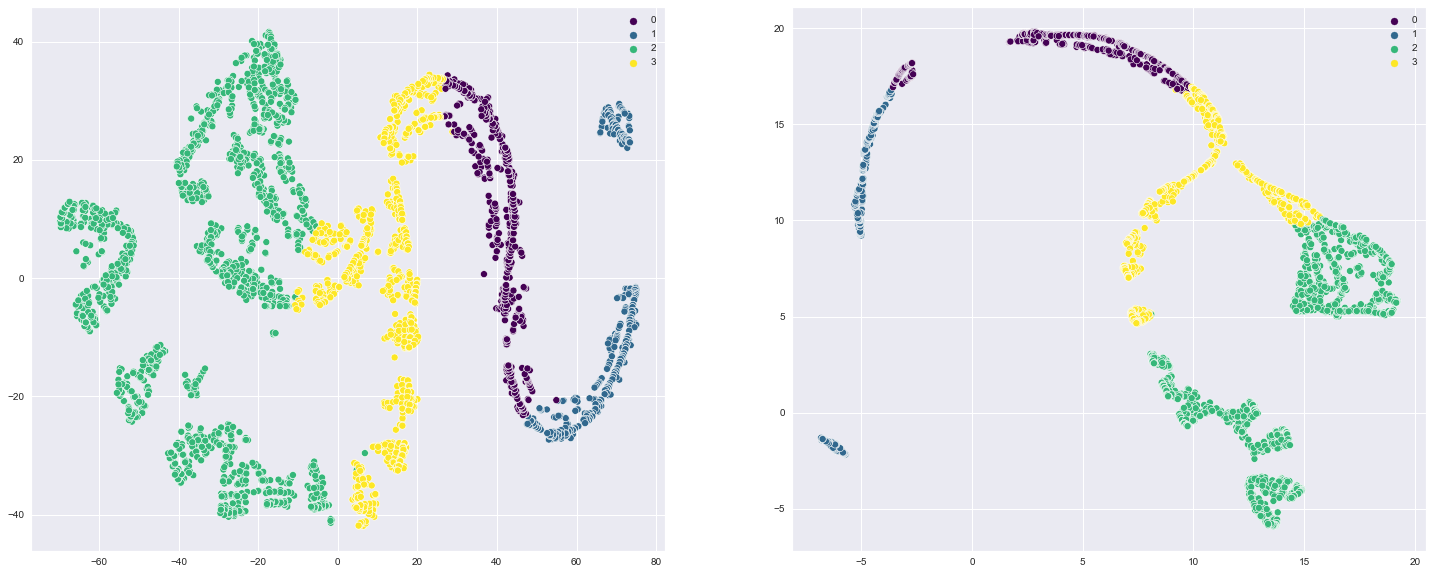

In [105]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

<AxesSubplot:>

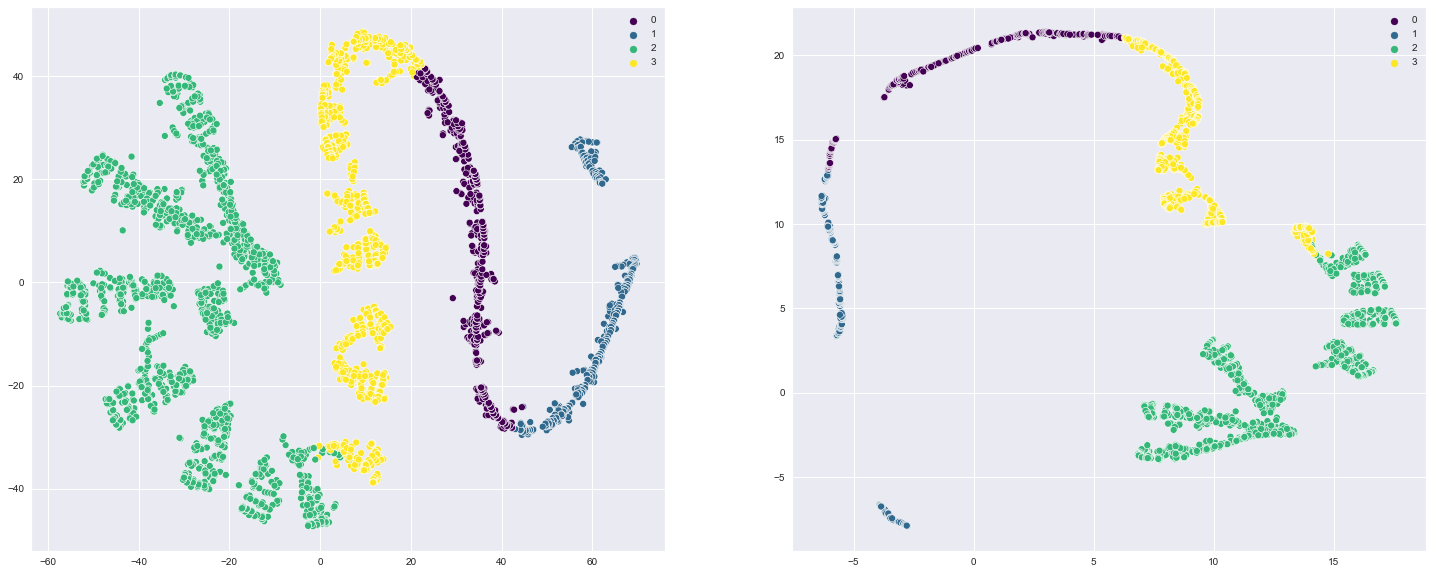

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='viridis')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='viridis')

In [128]:
#df_fselect['cluster'] = labels_tsne

## 9.2. Clusters Profile

In [106]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
#prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,total_spent,number_of_cancelations,avg_ticket
0,0,618,14.242913,191.040453,1.873786,603.412930,0.378641,34.513633
1,1,498,11.477299,308.369478,1.349398,392.575221,0.244980,32.739829
2,2,2130,49.089652,18.702347,6.499531,3131.647756,1.291080,29.284650
3,3,1093,25.190136,80.421775,2.618481,980.471804,0.468435,31.799894


In [ ]:
prof = cluster_df.groupby('cluster').count()['customer_id'].reset_index()
prof['percentual'] = (cluster_df.groupby('cluster').count()['customer_id']/cluster_df.shape[0])*100
prof['avg_recency'] = cluster_df.groupby('cluster').mean()['recency']
prof['avg_frequency'] = cluster_df.groupby('cluster').mean()['frequency']
#prof['avg_monetary'] = cluster_df.groupby('cluster').mean()['monetary']
prof['total_spent'] = cluster_df.groupby('cluster').mean()['total_spent']
prof['number_of_cancelations'] = cluster_df.groupby('cluster').mean()['number_of_cancelations']
prof['avg_ticket'] = cluster_df.groupby('cluster').mean()['avg_ticket']
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,total_spent,number_of_cancelations,avg_ticket
0,0,618,14.242913,191.040453,1.873786,603.412930,0.881877,34.513633
1,1,498,11.477299,308.369478,1.349398,392.575221,0.532129,32.739829
2,2,2130,49.089652,18.699061,6.497653,3127.423573,3.136620,29.271794
3,3,1093,25.190136,80.428179,2.622141,988.703744,1.213175,31.824948


In [ ]:
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,avg_monetary
0,0,418,9.633556,26.248804,12.490431,6008.355598
1,1,3,0.069140,3.000000,60.000000,244804.703333
2,2,38,0.875778,13.868421,34.947368,24694.783684
3,3,3865,89.075824,100.321863,2.840103,926.552337
4,4,15,0.345702,7.733333,55.333333,76398.306000


In [130]:
prof

,cluster,customer_id,percentual,avg_recency,avg_frequency,avg_monetary,avg_ticket
0,0,4071,93.115279,96.969295,3.641120,946.696250,25.359654
1,1,6,0.137237,7.166667,89.000000,182181.981667,253.626345
2,2,28,0.640439,6.178571,57.821429,42614.387143,162.862605
3,3,267,6.107045,20.280899,19.528090,8089.028652,62.783157


## 9.3 Report

Cluster 1

    - Number of Customers: 6
    - Percentage of Customers: 0.14%
    - Average Recency: 7.2 
    - Average Frequency: 89
    - Average Monetary: 182,181.98

Cluster 2

    - Number of Customers: 31
    - Percentage of Customers: 0.71%
    - Average Recency: 14 
    - Average Frequency: 53.3
    - Average Monetary: 40,543.52

Cluster 0

    - Number of Customers: 4335
    - Percentage of Customers: 99.15%
    - Average Recency: 92.26 
    - Average Frequency: 4.6
    - Average Monetary: 1,372.58

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


# 10.0. Deploy to Production